# Parte 3: Contornos activos

#### Autoría: María Pardo, Mariana Nakagawa, Gema Pérez

## Algoritmo snakes

En los anteriores *notebooks* hemos expuesto varios métodos de segmentación, y en este definiremos otro basado en la técnica de contornos activos.

Los bordes de una imagen son una característica importante a la hora de realizar análisis de imagen. Son alteraciones en la orientación de las superficies o modificaciones de las cualidades del material. El objetivo del método de contornos activos o "snakes", es aproximar una línea iterativamente alrededor de la región objetivo de tal manera que se acople lo máximo a sus bordes delimitantes, adaptándose así a su topología.

Al adaptarse, esta línea presenta una forma ondulante asemejándose a una serpiente y por ello se le denomina informalmente como 'snakes'.  

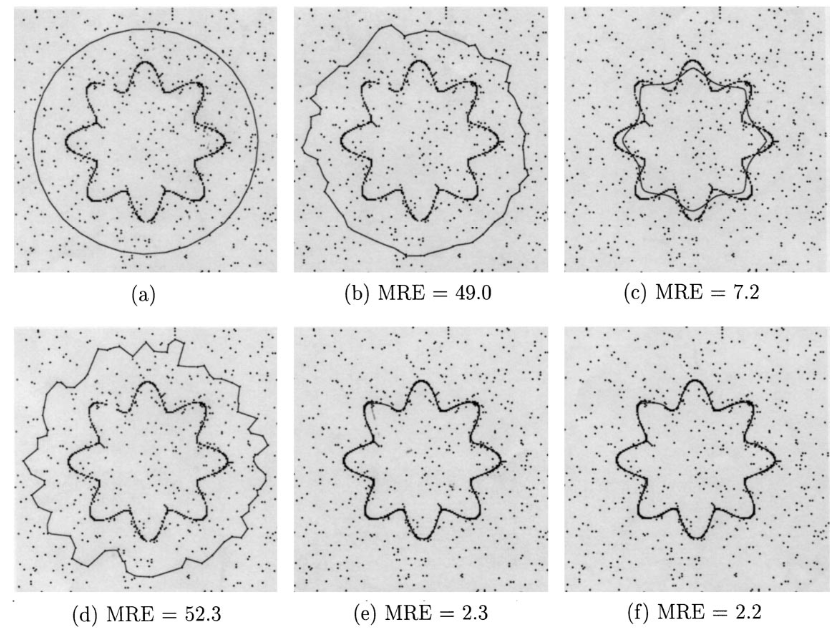


$$ C. Xu, J.L. Prince (1998) $$
(MRE: maximum radial  error) 

 ### ¿Cómo conseguimos que converja?
 
 Este algoritmo busca minimizar la energía de determinada por la imagen. Cuanto menor sea esta energía, mejor será la segmentación. Nuestra curva converge una vez logramos minimizar la energía de la curva. 
 
 $$ Energía = Energía_{interna} + Energía_{externa}$$

Si definimos a la curva **r**(s), 0 ≤ s ≤ 1 cuyo vector **r**(s) contiene las coordenadas (x,y) de los puntos de la recta:

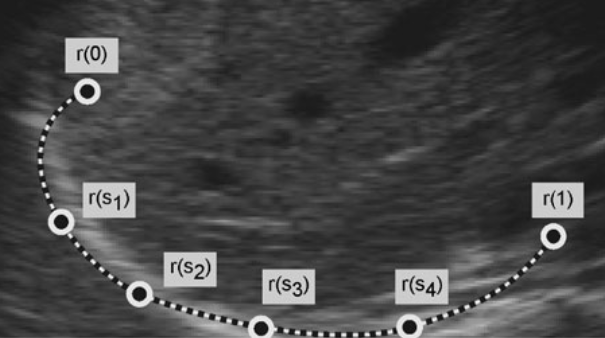

$$ Klaus D. Toennies (2012) $$

* La energía interna a minimizar se determina como:

$$ E_{interna}(\textbf{r}(s)) = w_1 \frac{∂\textbf{r}(s)}{∂s} + w_2\frac{∂^{2}\textbf{r}(s)}{∂s^{2}} = min ; w_1, w_2 > 0  $$

Esta energía está definida como la suma ponderada de la primera derivada parcial de **r**(s) (que se corresponde con la *elasticidad*) y  la segunda derivada parcial de **r**(s) (que se corresponde con la *rigidez*). La energía interna se comporta de manera similar a una goma elástica, excepto en situaciones extremas cuando se estira mucho hasta el punto de ruptura.

* Por otro lado, la energía externa está a menudo relacionada con el gradiente de la imagen, haciendo que el contorno activo siga los altos gradientes de la imagen.

$$ E_{externa}(\textbf{r}(s)) = - \lvert \nabla f(\textbf{r}(s)) \rvert = min  $$ 


De esta manera el criterio de convergencia es que cumpla la minimización de la energía total:


$$ \int_{0}^{1} E_{interna}(\textbf{r}(s)) +  E_{externa}(\textbf{r}(s))  \,ds = min $$




Al buscar una función que minimice la función anterior nos queda la siguiente expresión de Euler–Lagrange:

$$ -w_1 \frac{1}{∂s}(\frac{∂\textbf{r}(s)}{∂s}) + w_2 \frac{1}{∂s^{2}} (\frac{∂^{2}\textbf{r}(s)}{∂s^{2}}) + \nabla  E_{externa}( \textbf{r}(s)) = 0 $$




A partir de la ecuación anterior podemos llegar a una expresión que nos indica la manera en la que los puntos de la curva se van ajustando (tanto en la coordenada 'x' como en la 'y') por cada iteración, hasta que esta converge: 

$$ \textbf{x}^{(t+1)} = (\textbf{A} - \gamma \textbf{I})^{-1} ( \textbf{x}^{(t)} - \frac{∂ E(\textbf{s}^{(t)})}{∂ x} )$$


$$ \textbf{y}^{(t+1)} = (\textbf{A} - \gamma \textbf{I})^{-1} ( \textbf{y}^{(t)} - \frac{∂ E(\textbf{s}^{(t)})}{∂ x}) $$

* **A** es una matriz de constantes 
* **I** es la matriz identidad. 
*  $\gamma$ que corresponde con el coeficiente de actualización.
* El valor de t es el número de la iteración, estableciendo a t=0 como la primera iteración. 
* $\textbf{x}^{(t)}$ e $\textbf{y}^{(t)}$ son el valor estimado inicial para un punto de la curva.
* $\textbf{x}^{(t+1)}$ e $\textbf{y}^{(t+1)}$ son el valor del punto de la curva actualizado para la siguiente iteración.

$$ $$




### Implementamos el algoritmo de contorno activo de *skimage*

El esquema simplificado de lo que queremos implementar en el algoritmo *snakes* es el siguiente:

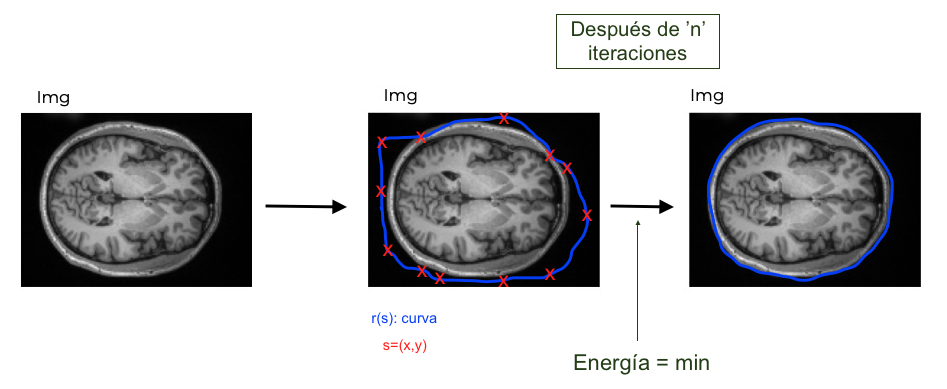

En la que la curva final que obtengamos segmentando la zona de la imagen corresponda con aquella que minimiza la energía total.

Procedemos con el código de skimage:

In [5]:
import numpy as np
import skimage
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.transform import resize

In [6]:
#cargamos la imagen 
img = nib.load('/Users/gemaperez/Imagen/bd_schizo/sub-01/anat/sub-01_T1w.nii.gz')  

from nilearn import plotting

#realizamos un resize de la imagen para ganar tiempo a la hora de ejecutar
a = np.array(skimage.transform.resize(img.dataobj, (120,180))) 
img= a[:,:,128] #obtenemos un corte 

#normalizamos
img_o=img
img_o=img_o/np.max(img_o) 

#convertimos la imagen a escala de grises
img= rgb2gray(img_o)

<ipython-input-6-458dacc6f46e>:15: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img= rgb2gray(img_o)


In [7]:
#generamos un array de 0 a 2pi de 400 datos de longitud
s = np.linspace(0, 2*np.pi, 400)

# generamos las funciones con las que vamos a construir la curva 
r = 60 + 55*np.sin(s) 
c = 85 + 70*np.cos(s)
init = np.array([r, c]).T



Implementamos la función de contornos de skimage. En este caso los parámetros son:

   *  **gamma**: (*float*), parámetro de salto de tiempo explícito.
   *  **beta**: (*float*), parámetro de suavidad de la forma de la serpiente. Valores más altos hacen que la serpiente sea más suave.
   *  **alpha**: (*float*), parámetro de forma de la longitud de la serpiente. Valores más altos hacen que la serpiente se contraiga más rápido.

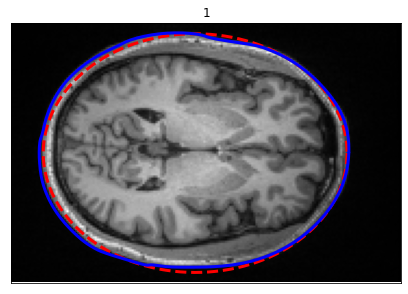

In [8]:
#implementamos la función de contornos activos de skimage


snake = active_contour(gaussian(img, 3),
                       init, alpha=0.004, beta=10, gamma=0.002, coordinates='rc') #Coordinates must be set in a row-column format.


fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
plt.title('1')

plt.show()

Probamos con uno de los hemisferios:

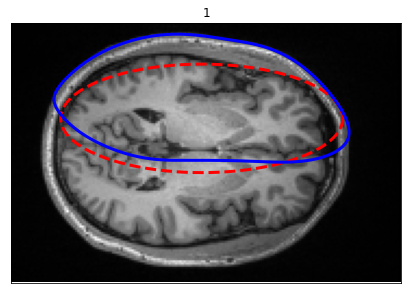

In [88]:
#generamos un array de 0 a 2pi de 400 datos de longitud
s = np.linspace(0, 2*np.pi, 400)

# generamos las funciones con las que vamos a construir la curva 
r = 44 + 25*np.sin(s) 
c = 88 + 65*np.cos(s)
init = np.array([r, c]).T



snake2 = active_contour(gaussian(img, 3),
                       init, alpha=0.002, beta=70, gamma=0.014, coordinates='rc') #Coordinates must be set in a row-column format.


fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake2[:, 1], snake2[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
plt.title('1')

plt.show()

##### * [Además: generar un contorno a mano]  (extra)

## Referencias

* Chenyang Xu, Jerry L. Prince (1998). '*Generalized gradient vector flow external forces for active contours*'. The Johns Hopkins University, Baltimore. https://www.sciencedirect.com/science/article/abs/pii/S0165168498001406
* Klaus D. Toennies (2012). '*Guide to Medical Image Analysis. Methods and Algorithms*'. 